# 0.주제/연구목표

- 모델
  - SBERT(Sentence-Bert)
  - Bert의 문장 임베딩 이 기능을 개선한 버전
  - SBERT를 사용하기 위해, transformers 패키지 설치하고 여기서 제공되는 sentence_transformers 모듈을 이용하여 구현

- 유사도 검사  
  - 문장을 백터화 시키면 수치화가 되어 있어서, 문장과 문장에 대한 유사도 계산을 할수 있다
  - 여기서는 코사인 유사도 계산식을 활용
    - 내 질문과 유사한 글을 찾아서(1에 가까운 코사인 유사도값) 그것에 연관된 답변을 가져온다
      - 질문지 데이터가 많을수록 오래 걸리는 구조 -> 챗봇에서 개선 방안

- 데이터
  - 함수로 구현해서 혹은 (라이브러리 가져와서 사용)
  - 챗봇에 사용될 질의/응답 데이터
  - https://github.com/songys/Chatbot_data
  - 송영숙님 제공
- 산출물
  - flask 기반 챗봇웹서비스
  - 템플릿 부트스트랩 기반
    - https://adminlte.io/themes/v3/
- 학습
  - 전이학습의 대체 트렌드로 제시된, 인컨텍스트 러닝의 제로샷 러닝 기법을 활용한다

# 1.Sentence 트랜스포머 설치

In [2]:
#!pip install transformers
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.0 MB/s 
     |████████████████████████████████| 4.7 MB 39.8 MB/s 
     |████████████████████████████████| 1.3 MB 39.2 MB/s 
     |████████████████████████████████| 120 kB 52.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=302aed1edab4e8520a3d95bb27ec7e6024d3b0ac38eae4c687ee447eb22d94ad
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


# 2.챗봇 구현을 위한 질문/답변지(시트) 데이터 획득

- git에 데이터를 등록하여 cdn 서비스 처럼 다운받아서 사용가능(일종의 저장소개념) 
- 데이터
  - https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
  - 챗봇 트레이닝용 문답 페어 11,876개
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
- 주소 형식
  - https://raw.githubusercontent.com/{소유자이름}/{repo}/{branch}/{file_name}



In [4]:
import urllib.request
import pandas as pd

In [5]:
# 원격지에 존재하는 리소스를 로컬 PC 특정 위치에 저장
# 만약 405가 뜨면, header쪽에 더미 user-agent값을 세팅한후 요청하면 처리된다
src_path    = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
target_path = 'chatbot_data.txt'
urllib.request.urlretrieve(src_path, target_path)

('chatbot_data.txt', <http.client.HTTPMessage at 0x7f892b95bdd0>)

# 3.EDA

In [6]:
# law 데이터를 DataFrame으로 변환
chatbot_df = pd.read_csv('/content/chatbot_data.txt')
chatbot_df.head(2)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0


In [9]:
# 결측 데이터 확인 -> 없음
chatbot_df.info(), chatbot_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


(None, Q        0
 A        0
 label    0
 dtype: int64)

In [10]:
# 정답의 종류
chatbot_df.label.unique()

array([0, 1, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


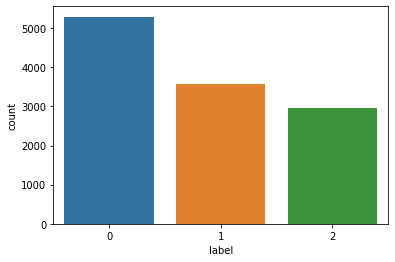

In [11]:
# 레이블별로 분량이 동일한지 확인 -> 여기서는 관계 없음
import seaborn as sns
sns.countplot( chatbot_df.label )

In [12]:
chatbot_df.shape

(11823, 3)

# 4.Pre-Trained Model Load

- 사전 훈련된 Bert 로드
- Sentence-Bert를 가져와서 활용
- NLI 데이터를 학습한후, STS 데이터로 파인 튜닝한 모델이다
- 용어
  - <a href='https://hryang06.github.io/nlp/KorNLI-KorSTS/'>용어 정리 참고</a>
- 모델 검색
  - https://huggingface.co/models?library=sentence-transformers
  - 사용 모델
    - https://huggingface.co/sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
model = SentenceTransformer( 'xlm-r-100langs-bert-base-nli-stsb-mean-tokens' )

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

- 사용하는 모델 특징
  - 100가지 언어를 지원(다국어 지원)
  - 다국어 Bert Base 모델 기반
  - SNLI 데이터를 학습
  - STS-B 데이터로 파인튜닝 진행
  - 평균 토큰활용(평균 풀링 활용) 문장 표현을 위해서

- 이 모델의 임베딩 값이 필요한것임

# 5.Q 데이터의 임베딩화 진행

- 유사도 계산을 위해서는 텍스트를 백터화 해야 하니까 (최종적으로는 임베딩값)

In [20]:
# 모델의 인코더를 이용하여 처리
# apply()를 이용하여 Q 데이터를 인코딩하여 새로운 컬럼 em 에 추가(파생변수 생성)한다
# DataFrame에서 apply()를 적용하는것과, Series에서 apply() 하는 방식은 조금 다름
chatbot_df[ 'em' ] = chatbot_df.Q.apply( lambda x: model.encode(x) )

In [21]:
# 임배딩이 완료된 df를 저장하여 백엔드에서 사용
# 파이썬의 모든 형식을 저장할수 있는 모듈
import pickle

In [22]:
# DataFrame 저장
def df_save(fName, src_df):
  '''
    DataFrame 저장
    fName : 저장할 파일명(경로포함)
    src_df : 저장할 데이터 DataFrame
  '''
  with open(fName, 'wb') as f:
   pickle.dump( src_df, f )

In [23]:
# DataFrame 로드
def df_load(fName):
  '''
    DataFrame 로드
    fName : 저장할 파일명(경로포함)
    return : 파일로부터 읽은 DataFrame
  '''
  with open(fName, 'rb') as f:
    df = pickle.load( f )
  return df

In [24]:
# 저장
df_save( '/content/drive/MyDrive/한국품질재단/딥러닝/DAY4/chatbot_df.dat', chatbot_df )

In [25]:
# 로드 : 백엔드에 이 파일을 가지고 이 함수를 호출해서 준비한다
tmp = df_load( '/content/drive/MyDrive/한국품질재단/딥러닝/DAY4/chatbot_df.dat' )
tmp.head(1)

,Q,A,label,em
0,12시 땡!,하루가 또 가네요.,0,"[0.20179586, -0.03443814, 1.5395721, 0.0106974..."


# 6.유사도 계산 함수 준비

- 코사인 유사도 계산식을 적용함 함수 구현

In [26]:
import numpy as np

In [28]:
def cos_sim(AVec, BVec):
  return np.dot(AVec, BVec) / ( np.linalg.norm(AVec) * np.linalg.norm(BVec) )

# 7.입력문자와 임베딩한 챗봇답변시트간의 탐색 및 유사도 계산 함수

- 유사도 최고 점수를 받은 답변을 찾는 함수

In [34]:
def check_answer_similar( userSentence='' ):
  if not userSentence:
    return '정확하게 입력후 문의하세요'
  # 1. 사용자의 입력 문자를 sbert 모델이 encode()를 호출하여 임베딩 한다 => 백터화
  embeddingSentence   = model.encode( userSentence )
  # 2. 데이터(챗봇 답변 컬럼(A))를 다 돌면서, 사용자가 입력한 문장과 유사도 계산해서 
  #    score 컬럼에 추가
  chatbot_df['score'] = chatbot_df.em.apply( lambda x: cos_sim( x, embeddingSentence) )
  # 3. 이중 최고 스코어를 받은 인덱스(idxmax)를 찾아서 문장을 리턴한다
  #    우연히 최고값이 2개 이상 나오면 가장 먼저 탐색된것이 추출된다
  return chatbot_df.loc[ chatbot_df['score'].idxmax() ]['A']

### TIP df상에서 최고값을 가진 데이터의 위치찾기

In [32]:
df = pd.DataFrame( [1,5,4,2,5] )
df

,0
0,1
1,5
2,4
3,2
4,5


In [33]:
df.loc[ df.idxmax()]

,0
1,5


# 8.테스트

In [36]:
while True:
  question = input('궁금한점 있으면 물어보세요\t\t')
  if question.lower() == 'q':
    break
  answer   = check_answer_similar( question )
  print( answer )

궁금한점 있으면 물어보세요		어떤 커피 좋아하세요
커피도 좋지만 차도 마셔보세요.
궁금한점 있으면 물어보세요		돈까스
쉽지 않은 결정이었을 거예요
궁금한점 있으면 물어보세요		추석이네
많이 힘든가봐요.
궁금한점 있으면 물어보세요		추석이다!!
즐거운 추석 보내세요!
궁금한점 있으면 물어보세요		방가
성덕이네요.
궁금한점 있으면 물어보세요		제주도
여행은 항상 좋죠.
궁금한점 있으면 물어보세요		q
